In [1]:
import numpy as np
from numpy.linalg import det, inv

from scipy.optimize import minimize

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator

from anneling_one import Annealing1

In [2]:
a1 = [1,0]; a2=[0,1];
A  = np.transpose([a1,a2]);

theta =  np.pi/4;
R = [ [ np.cos(theta), -np.sin(theta)], [ np.sin(theta),  np.cos(theta)] ];

b1 = np.sqrt(2)*np.dot(R,a1);  b2 = np.sqrt(2)*np.dot(R,a2); #a2
#b1 = [np.sqrt(2),0]; b2=[0,np.sqrt(2)];

B  = np.transpose([b1,b2]);

a = A#np.array([[0,1],[1,0]])
b = B#np.array([[0,5],[5,0]])

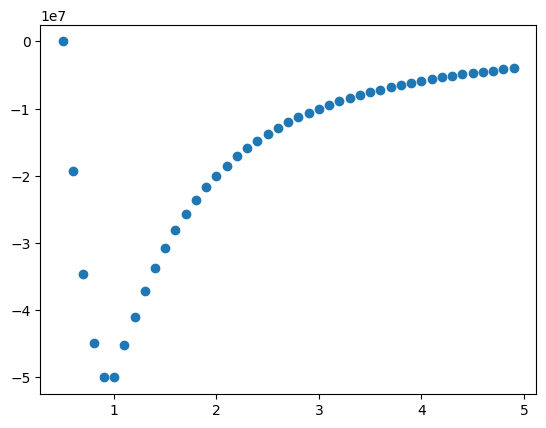

In [3]:
def at_sin(x, up =99999999):
    
    tr_x= (x + 0.5)
    
    if x<1:
        res = up*(1/(1+np.sqrt((x**2))) )* np.sin(tr_x*np.pi) +1/(x+0.00000000000001)
    else:
        res = (x-1)**2 -up*(1/(1+x**2))+1/(x+0.00000000000001)
    return res

X = [i*0.1 for i in range(0,50,1)]
Y= [at_sin(x) for x in X]

plt.scatter(X[5:],Y[5:])

In [4]:
def strain_tune(x, tB_,optimize=True):
    
    
    strain = np.array([[1+x[0],0],
                       [0,1+x[1]]])
    
    # Strain*tB_strained =tB_ => tB_strained=inv(Strain)*tB 
    if optimize:
        print(x)
        print("setst:",det(strain))
        tB_strain = np.dot(inv(strain),tB_)
        cons =99999
        tB_con = 0  
        for row in tB_strain:
            for e in row:
                tB_con += ((round(e)-e))*((round(e)-e)) # e*e
        tB_con = tB_con*cons+(x[1]**2+x[0]**2)*cons
        return tB_con
        
    return strain



In [5]:
def streined_proces(tB,strain_boundery):
    
#     def constraint1(x):
#         return 1 if (strain_boundery[0][0]<=x[0]<=strain_boundery[0][1]) and(strain_boundery[1][0]<=x[1]<=strain_boundery[1][1]) else 0
#     def constraint2(x):
# #         print("call",x)
        
#         return 0 if (1+x[1])*(1+x[0]) ==0 else  1
#     con1 = {'type': 'ineq', 'fun':constraint1}
#     con2 = {'type': 'ineq', 'fun':constraint2}
#     cons =([con1, con2])
    
    strain_cost = lambda x: strain_tune(x, tB_=tB)
    x0 = np.array([0, 0])
    res = minimize(strain_cost, x0, 
                   #constraints =cons,
                   bounds = strain_boundery,
                   method= 'L-BFGS-B'#'COBYLA'#L-BFGS-B',#
                  )
                   
                
#                options={'xatol': 1e-8, 'disp': True})
#     print("rx:",res.x)
#     print("cost:", strain_tune(res.x, tB, optimize=True))
    strein =  strain_tune(res.x, tB, optimize=False)
    return strein 

In [6]:
# a = np.array([[0,1],[1,0]])
# b = np.sqrt(2)*np.astrain_tune(res.x, tB, optimize=False)rray([[0,5],[5,0]])
eps = 0.0001

bond=10

def tAtB(params):
    tA = np.array([[params[0],params[1]],
                   [params[2],params[3]]])
    
    tB = np.dot(np.dot(tA,a), inv(b)) # tAa=tBb
    
    return tA, tB
          
def fit_fucntion(params , k_p=999,strain_boundery =[[-0.2e-9,0.2e-9],[-0.2e-9,0.2e-9]]):
          
        tA, tB= tAtB(params)
        tAa= np.dot(tA,a)
        tBb= np.dot(tB,b)
        
        
        # Strain tunning 
        strain = streined_proces(tB,strain_boundery)
        tB= np.dot(strain,tB)
        
        
        # main condition
        zero_mat= tAa - tBb
        s=0
        for row in zero_mat:
            for e in row:
                s+=e*e
        
        # mimimum TA
        detTAa= det(tAa)*det(tAa) # minimum but biger than 0
        detTBb= det(tBb)*det(tBb)
        
        # TB integer 
        cons =99999
        tB_con = 0  
        for row in tB:
            for e in row:
                tB_con += ((round(e)-e))*((round(e)-e)) # e*e
        tB_con = tB_con*cons
        
        tA_lenghth =((tA[0][0]**2+tA[0][1]**2)+(tA[1][0]**2+tA[1][1]**2) )*100
        
        
        f =  at_sin(detTAa)+ tB_con**2 +tA_lenghth
        #((1-detTAa)**2)*k_p + tB_con**2
        
        
        return f 

In [7]:
# Experiment settings

#Hyperparameters of the model
up = 99999999
bonds = [[-2*bond,2*bond] for _ in range(4)]

model_par = {
    
    'initialTemp': 4, 
    'finalTemp': 0.0003,

    'beta': 10,
    'bounds':[[-2*bond,2*bond] for _ in range(4)],

    'nr_neighbours': 1,
    'step_size': 4,
    'gaussian_sd':3,
    
    'known_min': -up,
    "start_point":[1,5,3,2,]
}



#
input_size = 4 # since our function has one variable this is a trivial scenario.
start_point = [1,5,3,2]

# Experiment
experiment = Annealing1(fit_fucntion ,start_point, model_par)

[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002


In [8]:
epochs= 10
history_book = experiment.evolve( epochs, prints_p=5)

[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
temp:4|epoch:0|change:7502387939.837538|value:2499978623.1005597
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-1

[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
temp:0.02484472049689441|epoch:0|change:100000100416878.98|value:-379879.9919747085
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.

[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
temp:0.014234875444839857|epoch:5|change:2535486961.3974285|value:-379879.9919747085
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0

temp:0.00997506234413965|epoch:5|change:2527223465.5210567|value:-379879.9919747085
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.

[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
temp:0.007130124777183602|epoch:0|change:843686.1640621466|value:-379879.9919747085
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.

[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002

[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002

[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002

[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
temp:0.0035682426404995546|epoch:5|change:32756828.911457382|value:-5869143.632352931
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 

[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
temp:0.0031225604996096804|epoch:5|change:10005906606.752792|value:-5869143.632352931
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 

[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
temp:0.0027758501040943797|epoch:5|change:2521604861.5345654|value:-5869143.632352931
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 

[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
temp:0.00249843847595253|epoch:0|change:100000105881942.62|value:-5874543.632352958
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.

[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002

[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
temp:0.0021265284423179166|epoch:0|change:2505678075.514987|value:-5874543.632352958
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0

[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002

[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
temp:0.0018509949097639986|epoch:0|change:2506176967.476799|value:-5874543.632352958
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0

[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
temp:0.0017233950883239987|epoch:0|change:2506361039.7164297|value:-5874543.632352958
[0. 

[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
temp:0.0016386726751331426|epoch:0|change:10213042745.150059|value:-5874543.632352958
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 

[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
temp:0.0015618898867629837|epoch:5|change:2505946420.2958164|value:-5874543.632352958
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e

[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
temp:0.001491980604252145|epoch:5|change:2506463570.191249|value:-5874543.632352958
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.

[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
temp:0.0013884068031933359|epoch:0|change:10220028744.165825|value:-5874543.632352958
[0. 

[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
temp:0.0013153567905294311|epoch:0|change:2507336153.2443027|value:-5874543.632352958
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 

[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
temp:0.0012654223347042075|epoch:0|change:10023533315.030472|value:-5874543.632352958
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 

[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
temp:0.0011761246692149365|epoch:0|change:55664766.62394374|value:-5874543.632352958
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0

[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
temp:0.001136040897472309|epoch:5|change:6693621.176827595|value:-5874543.632352958
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.

[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
temp:0.0010866612333604996|epoch:5|change:2513725295.209194|value:-5874543.632352958
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0

[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
temp:0.0010413954699297053|epoch:0|change:2508144000.657353|value:-5874543.632352958
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0

[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
temp:0.0009997500624843783|epoch:0|change:10014840109.70438|value:-5874543.632352958
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0

[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
temp:0.0009706381946129574|epoch:0|change:2609889242.921444|value:-5874543.632352958
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-

[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002

[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
temp:0.000908884344467166|epoch:5|change:2509940995.496304|value:-5876943.6323529435
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0

[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002

[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
temp:0.0008545182653279207|epoch:5|change:2571441643.358296|value:-5876943.6323529435
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 

[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
temp:0.0008262755629002267|epoch:0|change:10006870404.310644|value:-5876943.6323529435
[0.

[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
temp:0.0008062890546260829|epoch:5|change:10006216140.466393|value:-5876943.6323529435
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.

[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002

[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
temp:0.0007574323044877859|epoch:0|change:2693218187.348758|value:-5876943.6323529435
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 

[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
temp:0.0007351589781290198|epoch:0|change:2632081868.090329|value:-5876943.632352931
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0

[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0

[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002

[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002

temp:0.0006621420294653197|epoch:0|change:6041319.638765407|value:-5876943.632352931
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0

[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
temp:0.0006450572488308331|epoch:0|change:9655941.95266375|value:-5876943.632352931
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.

[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
temp:0.0006328112640404994|epoch:5|change:5944642.780650899|value:-5876943.632352931
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0

[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
temp:0.0006171887054466898|epoch:0|change:2506652321.4268146|value:-5876943.632352931
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e

[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
temp:0.0006023189278723081|epoch:0|change:7575709.095742514|value:-5876943.6323529435
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 

[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002

[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
temp:0.0005746300818847864|epoch:0|change:10694413393.487093|value:-5876943.6323529435
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0.

[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
temp:0.0005617188597107145|epoch:0|change:2505855566.7329125|value:-5876943.6323529435
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0.

[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
temp:0.0005524098881369973|epoch:5|change:10005710667.482878|value:-5876943.6323529435
[0.

[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002

[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002

[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
temp:0.0005207655253222236|epoch:0|change:2506766335.602235|value:-5876943.6323529435
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e

[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002

[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
temp:0.0004999375078115236|epoch:0|change:2527217968.2055793|value:-5876943.6323529435
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0.

[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
temp:0.0004925501785494397|epoch:5|change:213234144.1501691|value:-5876943.6323529435
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 

[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002

[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
temp:0.000473877502665561|epoch:0|change:2499955100.2499943|value:-5881743.632352941
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0

[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
temp:0.00046506220206952694|epoch:0|change:2505758767.90858|value:-5881743.632352941
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0

[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
temp:0.0004565688848304991|epoch:0|change:2511606026.536099|value:-5881743.632352941
[0. 0

[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002

temp:0.0004424289348523397|epoch:0|change:2507928844.9245534|value:-5881743.632352941
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 

[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
temp:0.0004347353548527338|epoch:5|change:2510322646.5487065|value:-5881743.632352941
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 

[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
temp:0.0004273047751308624|epoch:0|change:16799.999999997206|value:-5881743.632352941
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 

[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
temp:0.00042189642442780323|epoch:5|change:2505996019.8887568|value:-5881743.632352941
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0.

[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002

[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002

[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
temp:0.0004015661078205002|epoch:0|change:32760028.91145739|value:-5881743.632352941
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0

[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
temp:0.0003952178638474463|epoch:0|change:2455842845.382347|value:-5881743.632352941
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0

[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
temp:0.000389067211360763|epoch:0|change:10024663564.362358|value:-5881743.632352941
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0

[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
temp:0.0003845784059225078|epoch:5|change:29898540.467625897|value:-5881743.632352941
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 

[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
temp:0.0003773228940665979|epoch:0|change:10018663537.916521|value:-5881743.632352941
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 

[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
temp:0.00037171266610909817|epoch:0|change:2529854840.717615|value:-5881743.632352941
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 

[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
temp:0.00036626682538229156|epoch:0|change:2515676458.714366|value:-5881743.632352941
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 

[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002

[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
temp:0.00035711097223462245|epoch:5|change:10005714267.482864|value:-5881743.632352941
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0.

[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
temp:0.0003520816829504451|epoch:0|change:2544786041.3151135|value:-5881743.632352941
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 

[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002

[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
temp:0.00034361309165879274|epoch:5|change:2506457570.1912537|value:-5881743.632352941
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0.

[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002

[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002

[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002

[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002

[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
temp:0.0003225546326909125|epoch:0|change:2505997219.8887568|value:-5881743.632352941
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e

[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
temp:0.0003184459836000323|epoch:0|change:2508664008.4942536|value:-5881743.632352941
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 

[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
temp:0.00031543253686617823|epoch:5|change:2601895242.8414173|value:-5881743.632352941
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0.

[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
temp:0.000311502219453314|epoch:5|change:10005702371.341|value:-5881743.632352941
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]


[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002

[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
temp:0.000304854812895359|epoch:5|change:2505856270.591019|value:-5881743.632352941
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.

[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002

In [9]:
solution = experiment.actual_solution
tA ,tB =tAtB(solution )
zero_mat= np.dot(tA,a) - np.dot(tB,b)
print("\n _____\n tA:\n",tA)
print("det:",det(tA))
print("\n _____\n tB:\n",tB)
print("det:",det(tB))
print("\n zero_mat:\n",zero_mat)




 _____
 tA:
 [[ 1 -1]
 [ 0  2]]
det: 2.0

 _____
 tB:
 [[ 1.  0.]
 [-1.  1.]]
det: 0.9999999999999996

 zero_mat:
 [[0.00000000e+00 0.00000000e+00]
 [4.93038066e-32 0.00000000e+00]]


In [10]:
tB

array([[ 1.,  0.],
       [-1.,  1.]])

In [14]:
strain = streined_proces(tB,strain_boundery =[[-0.2e-9,0.2e-9],[-0.2e-9,0.2e-9]])#strain_boundery=[[0.2,0.5],[0.5,0.5]])
print("strain:\n",strain)
print("tB strain:\n",np.dot(strain,tB))

[0. 0.]
setst: 1.0
[2.e-10 0.e+00]
setst: 1.0000000002
[0.e+00 2.e-10]
setst: 1.0000000002
strain:
 [[1. 0.]
 [0. 1.]]
tB strain:
 [[ 1.  0.]
 [-1.  1.]]


In [12]:
#StB=tB_round
def get_strain(tB):
    tBr= tB.copy()
    for i in range(len(tB)):
        for j in range(len(tB[0])):
            tBr[i][j]=round(tB[i][j])
    S =np.dot(tBr,inv(tB))
    return(S)

S= get_strain(tB)
print("Strain:",get_strain(tB))

Strain: [[1. 0.]
 [0. 1.]]


Text(0.5, 1.0, 'Values')

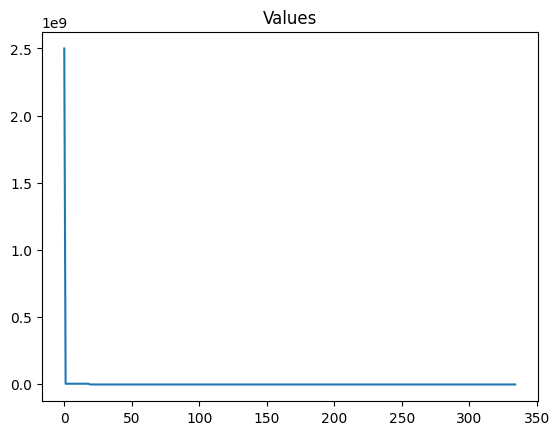

In [13]:
plt.plot(history_book['values'])
plt.title("Values")